In [1]:
from keras import layers, models, optimizers
from keras import datasets
from keras import backend
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [2]:
class UNET(models.Model):
    def __init__(self, org_shape, n_ch):
    channel_index = 3 if backend.image_data_format() == 'channels_last' else 1

    def conv(x, n_f, mp_flag=True):
      x = layers.MaxPooling2D((2, 2), padding='same')(x) if mp_flag else x
      x = layers.Conv2D(n_f, (3, 3), padding='same')(x)
      x = layers.BatchNormalization()(x)
      x = layers.Activation('tanh')(x)
      x = layers.Conv2D(n_f, (3, 3), padding='same')(x)
      x = layers.BatchNormalization()(x)
      x = layers.Activation('tanh')(x)
      return x
    
    def deconv_unet(x, e, n_f):
      x = layers.UpSampling2D((2, 2))(x)
      x = layers.Concatenate(axis=channel_index)([x, e])
      x = layers.Conv2D(n_f, (3, 3), padding='same')(x)
      x = layers.BatchNormalization()(x)
      x = layers.Activation('tanh')(x)
      x = layers.Conv2D(n_f, (3, 3), padding='same')(x)
      x = layers.BatchNormalization()(x)
      x = layers.Activation('tanh')(x)
      return x
    
    original = layers.Input(shape=org_shape)
    
    c1 = conv(original, 16, False)
    c2 = conv(c1, 32)
    encoded = conv(c2, 64)
    
    x = deconv_unet(encoded, c2, 32)
    x = deconv_unet(x, c1, 16)
    decoded = layers.Conv2D(n_ch, (3, 3), activation='sigmoid',
                           padding='same')(x)
    
    super().__init__(original, decoded)
    self.compile(optimizer='adadelta', loss='mse')

In [3]:
class DATA():
    def __init__(self):
    (x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

    if backend.image_data_format() == 'channels_first':
      n_ch, img_rows, img_cols = x_train.shape[1:]
      input_shape = (1, img_rows, img_cols)
    else:
      img_rows, img_cols, n_ch = x_train.shape[1:]
      input_shape = (img_rows, img_cols, 1)

    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    
    def RGB2Gray(img, fmt):
      if fmt == 'channels_first':
        R = img[:, 0:1]
        G = img[:, 1:2]
        B = img[:, 2:3]
      else:
        R = img[..., 0:1]
        G = img[..., 1:2]
        B = img[..., 2:3]
      return 0.299 * R + 0.587 * G + 0.114 * B
    
    x_train_in = RGB2Gray(x_train, backend.image_data_format())
    x_test_in = RGB2Gray(x_test, backend.image_data_format())
    
    self.input_shape = input_shape
    self.x_train_in, self.x_train_out = x_train_in, x_train
    self.x_test_in, self.x_test_out = x_test_in, x_test
    self.n_ch = n_ch

In [4]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc=0)
 
def plot_acc(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc=0)

In [5]:
def show_images(in_imgs, out_imgs, unet, sample_size=10):
  x_test_in = in_imgs[:sample_size]
  x_test_out = out_imgs[:sample_size]
  decoded_imgs = unet.predict(x_test_in, batch_size=sample_size)
  
  print("Before")
  print("x_test_in:", x_test_in.shape)
  print("decoded_imgs:", decoded_imgs.shape)
  print("x_test_out:", x_test_out.shape)
  
  if backend.image_data_format() == 'channels_first':
    x_test_out = x_test_out.swapaxes(1, 3).swapaxes(1, 2)
    decoded_imgs = decoded_imgs.swapaxes(1, 3).swapaxes(1, 2)
    
    x_test_in = x_test_in[:, 0, ...]
  else:
    x_test_in = x_test_in[..., 0]
  
  print("After")
  print("x_test_in:", x_test_in.shape)
  print("decoded_imgs:", decoded_imgs.shape)
  print("x_test_out:", x_test_out.shape)
    
  plt.figure(figsize=(20, 6))
  for i in range(sample_size):
    ax = plt.subplot(3, sample_size, i + 1)
    plt.imshow(x_test_in[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, sample_size, i + 1 + sample_size)
    plt.imshow(decoded_imgs[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, sample_size, i + 1 + sample_size * 2)
    plt.imshow(x_test_out[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
  plt.show()

170500096/170498071 [==============================] - 1604s 9us/step
Train on 40000 samples, validate on 10000 samples
Epoch 1/10
 - 374s - loss: 0.0136 - val_loss: 0.0582
Epoch 2/10
 - 404s - loss: 0.0091 - val_loss: 0.0129
Epoch 3/10
 - 448s - loss: 0.0082 - val_loss: 0.0088
Epoch 4/10
 - 453s - loss: 0.0076 - val_loss: 0.0080
Epoch 5/10
 - 403s - loss: 0.0073 - val_loss: 0.0072
Epoch 6/10
 - 392s - loss: 0.0070 - val_loss: 0.0148
Epoch 7/10
 - 411s - loss: 0.0068 - val_loss: 0.0065
Epoch 8/10
 - 439s - loss: 0.0067 - val_loss: 0.0201
Epoch 9/10
 - 426s - loss: 0.0066 - val_loss: 0.0104
Epoch 10/10
 - 416s - loss: 0.0065 - val_loss: 0.0074
Before
x_test_in: (10, 32, 32, 1)
decoded_imgs: (10, 32, 32, 3)
x_test_out: (10, 32, 32, 3)
After
x_test_in: (10, 32, 32)
decoded_imgs: (10, 32, 32, 3)
x_test_out: (10, 32, 32, 3)


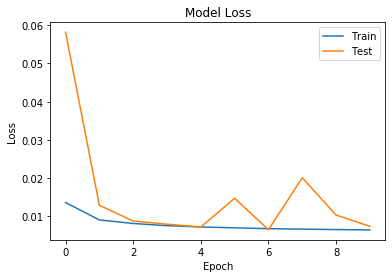

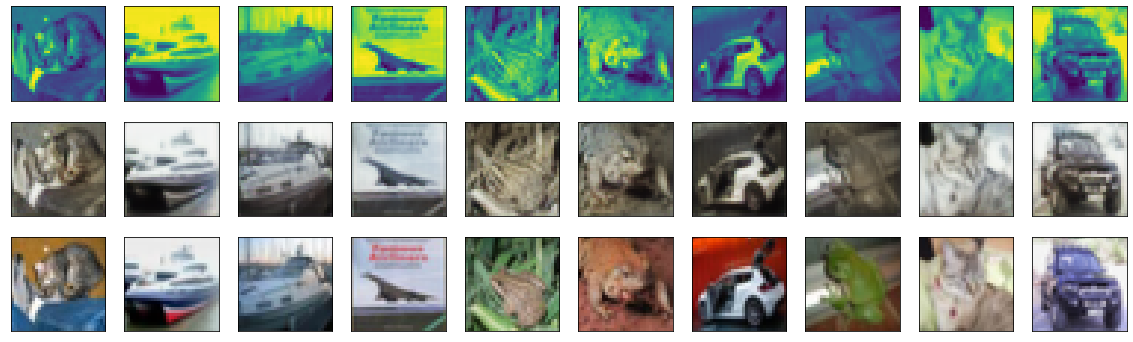

In [6]:
def main(epochs=10, batch_size=128):
  data = DATA()
  unet = UNET(data.input_shape, data.n_ch)
  
  history = unet.fit(data.x_train_in, data.x_train_out,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=2)
  
  plot_loss(history)
  show_images(data.x_test_in, data.x_test_out, unet)
  
if __name__ == '__main__':
  main()

In [17]:
plot_acc(history)

NameError: name 'history' is not defined

In [12]:
data = DATA()
unet = UNET(data.input_shape, data.n_ch)
unet.summary()

Model: "unet_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 32, 32, 16)   160         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 32, 32, 16)   64          conv2d_12[0][0]                  
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 32, 32, 16)   0           batch_normalization_11[0][0]     
_____________________________________________________________________________________________